In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time
import os

In [19]:
#set these paths to your model files ---
YOLO_CFG = "yolov3.cfg"        # or yolov4.cfg, or path to an ONNX model
YOLO_WEIGHTS = "yolov3.weights"
YOLO_NAMES = "coco.names"
CONF_THRESHOLD = 0.4
NMS_THRESHOLD = 0.4
# -----------------------------------------------

def load_yolo(cfg_path=YOLO_CFG, weights_path=YOLO_WEIGHTS, names_path=YOLO_NAMES, use_cuda=False):
    if not (os.path.exists(cfg_path) and os.path.exists(weights_path) and os.path.exists(names_path)):
        print("YOLO files not found. Please place cfg, weights and names in the notebook folder and re-run.")
        return None
    net = cv2.dnn.readNet(weights_path, cfg_path)
    # optional: enable CUDA if available
    if use_cuda:
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    classes = []
    with open(names_path, "r") as f:
        classes = [c.strip() for c in f.readlines() if c.strip()]
    # get output layer names
    layer_names = net.getLayerNames()
    try:
        out_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except:
        out_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, classes, out_layers

def detect_yolo(net, out_layers, frame, input_size=416, conf_thresh=CONF_THRESHOLD, nms_thresh=NMS_THRESHOLD):
    # Returns list of detections: (class_id, conf, box) where box = (x,y,w,h)
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (input_size, input_size), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(out_layers)
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            if len(scores) == 0:
                continue
            class_id = int(np.argmax(scores))
            conf = float(scores[class_id])
            if conf > conf_thresh:
                center_x = int(detection[0] * w)
                center_y = int(detection[1] * h)
                bw = int(detection[2] * w)
                bh = int(detection[3] * h)
                x = int(center_x - bw/2)
                y = int(center_y - bh/2)
                boxes.append([x, y, bw, bh])
                confidences.append(conf)
                class_ids.append(class_id)
    # NMS
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_thresh, nms_thresh)
    detections = []
    if len(idxs) > 0:
        # idxs may be a list of lists or a flat list depending on OpenCV version
        try:
            iter(idxs.flatten())
            idx_list = idxs.flatten()
        except:
            idx_list = idxs
        for i in idx_list:
            detections.append((class_ids[i], confidences[i], boxes[i]))
    return detections

In [20]:
def fake_depth_map(frame):
    # Simulated depth map: higher values = nearer (normalized 0..1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    depth = cv2.GaussianBlur(gray, (31,31), 0)
    depth = cv2.normalize(depth.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return depth

# --- MiDaS placeholder: user must provide MiDaS ONNX file ---
MIDAS_ONNX = "midas.onnx"
def load_midas(onnx_path=MIDAS_ONNX, use_cuda=False):
    if not os.path.exists(onnx_path):
        print("MiDaS ONNX not found. Using fake depth. Place `midas.onnx` to enable MiDaS.")
        return None
    net = cv2.dnn.readNet(onnx_path)
    if use_cuda:
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    return net

def midas_depth(net, frame, target_size=384):
    inp = cv2.resize(frame, (target_size, target_size))
    blob = cv2.dnn.blobFromImage(inp, 1/255.0, (target_size, target_size), mean=(0.485,0.456,0.406), swapRB=True, crop=False)
    net.setInput(blob)
    out = net.forward()
    out = out[0, :, :]
    out = cv2.resize(out, (frame.shape[1], frame.shape[0]))
    out = cv2.normalize(out, None, 0.0, 1.0, cv2.NORM_MINMAX)
    return out

In [21]:
def estimate_distance_from_depth(depth_map, box):
    # depth_map normalized 0..1 where higher means nearer (by our convention).
    x, y, w, h = box
    cx = int(x + w/2)
    cy = int(y + h/2)
    cx = np.clip(cx, 0, depth_map.shape[1]-1)
    cy = np.clip(cy, 0, depth_map.shape[0]-1)
    patch = depth_map[max(0,cy-5):min(depth_map.shape[0],cy+6), max(0,cx-5):min(depth_map.shape[1],cx+6)]
    if patch.size == 0:
        return 0.0
    return float(np.mean(patch))

def avoidance_decision_from_detections(frame, detections, depth_map, target_classes=None, close_thresh=0.6):
    h, w = frame.shape[:2]
    center_x = w // 2
    decision = "Move Forward"
    reason = ""
    for class_id, conf, box in detections:
        if target_classes and class_id not in target_classes:
            continue
        dist = estimate_distance_from_depth(depth_map, box)
        x, y, bw, bh = box
        obj_center = x + bw//2
        if dist > close_thresh:
            if obj_center < center_x - bw*0.3:
                decision = "Turn Right"
                reason = f"Close object left (conf={conf:.2f}, d={dist:.2f})"
            elif obj_center > center_x + bw*0.3:
                decision = "Turn Left"
                reason = f"Close object right (conf={conf:.2f}, d={dist:.2f})"
            else:
                decision = "STOP - Obstacle Ahead"
                reason = f"Centered close object (conf={conf:.2f}, d={dist:.2f})"
            break
    return decision, reason

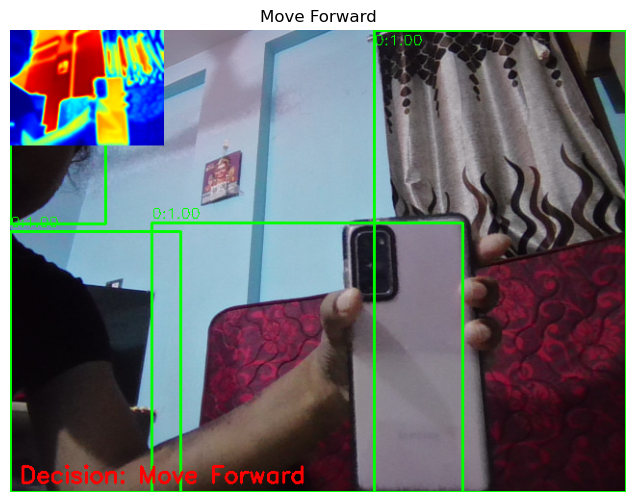

In [ ]:
# Load models if available
yolo = load_yolo()  # returns (net, classes, out_layers) or None
midas_net = load_midas()  # returns net or None

if yolo is not None:
    net, classes, out_layers = yolo
else:
    net = out_layers = classes = None

cap = cv2.VideoCapture(0)
time.sleep(0.5)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Camera not available or frame not read.")
            break

        # Depth: prefer MiDaS if available
        if midas_net is not None:
            depth_map = midas_depth(midas_net, frame)
        else:
            depth_map = fake_depth_map(frame)

        # Detections: prefer YOLO if available
        if net is not None:
            detections = detect_yolo(net, out_layers, frame)
        else:
            # fallback: simple dark-object detector
            boxes = []
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)
            mask = cv2.medianBlur(mask, 7)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area > 500:
                    x,y,w,h = cv2.boundingRect(cnt)
                    boxes.append((0, 1.0, [x,y,w,h]))  # fake class/conf
            detections = boxes

        decision, reason = avoidance_decision_from_detections(frame, detections, depth_map)
        # visualization
        vis = frame.copy()
        for class_id, conf, box in detections:
            x,y,w,h = box
            cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 2)
            label = f"{classes[class_id] if classes and class_id < len(classes) else class_id}:{conf:.2f}"
            cv2.putText(vis, label, (x, max(15,y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        # overlay depth as small inset
        depth_vis = (depth_map*255).astype(np.uint8)
        depth_vis = cv2.resize(depth_vis, (frame.shape[1]//4, frame.shape[0]//4))
        depth_vis = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)
        dh, dw = depth_vis.shape[:2]
        vis[0:dh, 0:dw] = depth_vis

        # decision text
        cv2.putText(vis, f"Decision: {decision}", (10, frame.shape[0]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

        clear_output(wait=True)
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        if reason:
            plt.title(f"{decision} — {reason}")
        else:
            plt.title(decision)
        plt.show()

        # small sleep to yield to Jupyter
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    print("Interrupted by user")
finally:
    cap.release()
    cv2.destroyAllWindows()